In [47]:
import os
import sys
import numpy as np
import json
import cv2
import skimage
import matplotlib
import matplotlib.pyplot as plt
from PIL import ImageDraw, Image

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [48]:
class CustomDataset(utils.Dataset):

    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']+1
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )


    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "custom":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [49]:
TRAIN_DATASET_PATH=os.path.join(ROOT_DIR, "dataset\\train")
TRAIN_JSON_PATH=os.path.join(ROOT_DIR, "dataset\\train\\_annotations.coco.json")
VAL_DATASET_PATH=os.path.join(ROOT_DIR, "dataset\\valid")
VAL_JSON_PATH=os.path.join(ROOT_DIR, "dataset\\valid\\_annotations.coco.json")
# Training dataset
dataset_train = CustomDataset()
dataset_train.load_data(TRAIN_JSON_PATH, TRAIN_DATASET_PATH)
dataset_train.prepare()

# Validation dataset
dataset_val = CustomDataset()
dataset_val.load_data(VAL_JSON_PATH, VAL_DATASET_PATH)
dataset_val.prepare()

In [50]:
from sklearn.decomposition import PCA
from keras.preprocessing import image

# Initialize empty arrays to store features and labels
features = []
labels = []

for image_id in dataset_train.image_ids:
    # Load and preprocess the image
    image_path = dataset_train.image_info[image_id]['path']
    img = image.load_img(image_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)

    # Extract features using the pre-trained model
    features.append(img.flatten())
    
    # Get the class label of the image
    mask, class_ids = dataset_train.load_mask(image_id)
    labels.append(class_ids[0])

# Convert features and labels to numpy arrays
features = np.array(features)
labels = np.array(labels)

# Step 3: Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)

pc1 = pca_result[:, 0]
pc2 = pca_result[:, 1]

In [51]:
def plot_scatter(pc1, pc2, labels):
    fig, ax = plt.subplots(figsize=(15, 8))
    species_unique = list(set(labels))
    species_colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink']
    for i, spec in enumerate(labels):
        plt.scatter(pc1[i], pc2[i], label = spec, s = 20,
        c=species_colors[species_unique.index(spec)])
        ax.annotate(str(i+1), (pc1[i],pc2[i]))
    from collections import OrderedDict
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), prop={'size': 15}, loc=4)
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.axhline(y=0, color="grey", linestyle="--")
    ax.axvline(x=0, color="grey", linestyle="--")
    plt.show()

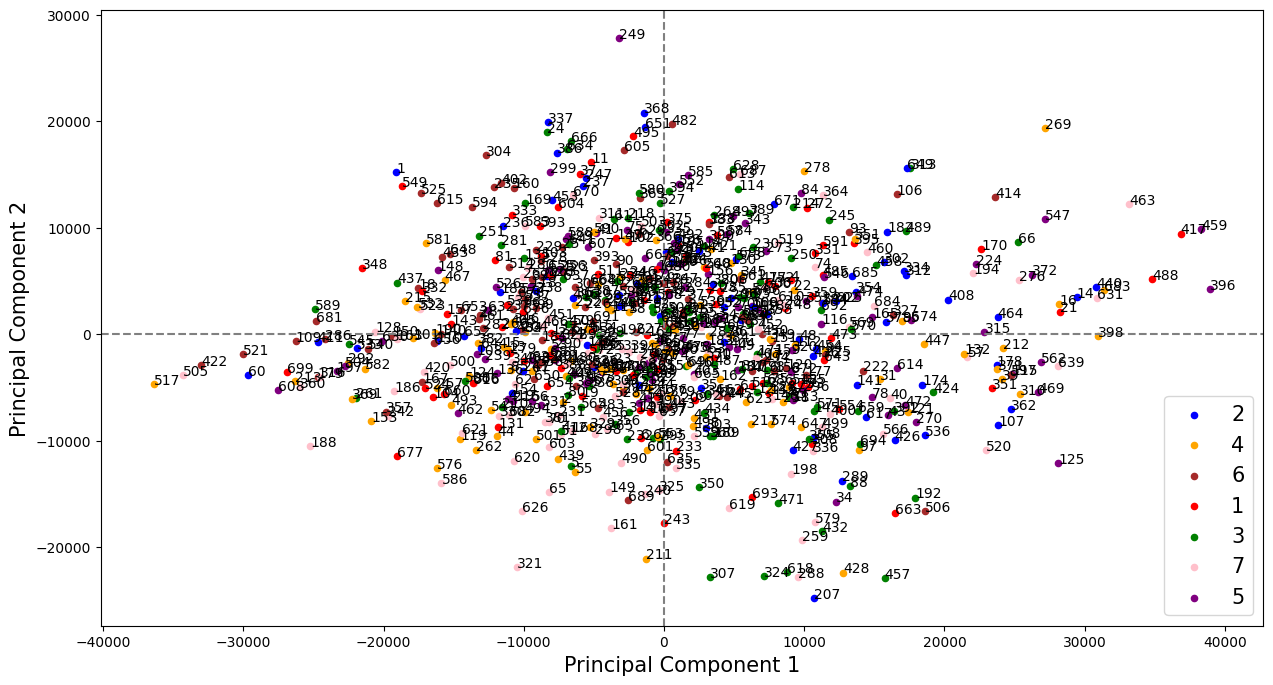

In [52]:
plot_scatter(pc1, pc2, labels)